# Tully-Fisher Secondary Target Sample

Demonstrate SQLite3 access to the TF targets in the secondary target database at NERSC.

In [605]:
import os
import csv
from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, unique, Table, QTable
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy import constants
from desispec.spectra import stack as specstack
from desispec.io import read_spectra, write_spectra

import numpy as np
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt

In [606]:
mpl.rc('font', size=16)
mpl.rc('axes', titlesize='small')

In [607]:
import sqlite3
from contextlib import closing

## SQLite3 Query

See if we have a cached copy of the query results (in FITS format) before running this query.

Use this query or the csv file to obtain the data.

In [710]:
'''
# Change use_cached = False if we want to redo the query at some point.
use_cached = True

if os.path.exists('tf_targets.fits') and use_cached:
    tf_targets = Table.read('tf_targets.fits')
else:
    query = "select distinct pv.BRICKID, pv.OBJID, ifnull(pv.SGA_ID, 0), pv.POINTINGID, fd.TARGETID, fd.TARGET_RA, fd.TARGET_DEC, pv.PVTYPE, zd.Z, zd.ZERR, zd.SPECTYPE, zd.DELTACHI2, zd.ZWARN \
            from (select distinct BRICKID, OBJID, PVTYPE, SGA_ID, POINTINGID from proposals_pv \
            where (PVTYPE like 'TFT' or PVTYPE like 'EXT' or PVTYPE like 'SGA')) pv \
            inner join fibermap_daily fd \
            on (pv.BRICKID = fd.BRICKID) and (pv.OBJID = fd.BRICK_OBJID) \
            inner join zbest_daily zd \
            on zd.TARGETID=fd.TARGETID \
            group by pv.BRICKID, pv.OBJID, fd.TARGETID;"

    with closing(sqlite3.connect('/global/cfs/cdirs/desi/science/td/db/desi.db')) as db:
        with closing(db.cursor()) as cursor:
            rows = cursor.execute(query).fetchall()

    tf_targets = Table(list(map(list, zip(*rows))),
                        names=['BRICKID', 'FIBER_RA','FIBER_DEC', 'OBJID', 'SGA_ID', 'POINTINGID', 'TARGETID', 'TARGET_RA', 'TARGET_DEC', 'PVTYPE', 'Z', 'ZERR', 'SPECTYPE', 'DELTACHI2', 'ZWARN'])
    
    # Cache output for later.
    tf_targets.write('tf_targets.fits', overwrite=True)
'''

'\n# Change use_cached = False if we want to redo the query at some point.\nuse_cached = True\n\nif os.path.exists(\'tf_targets.fits\') and use_cached:\n    tf_targets = Table.read(\'tf_targets.fits\')\nelse:\n    query = "select distinct pv.BRICKID, pv.OBJID, ifnull(pv.SGA_ID, 0), pv.POINTINGID, fd.TARGETID, fd.TARGET_RA, fd.TARGET_DEC, pv.PVTYPE, zd.Z, zd.ZERR, zd.SPECTYPE, zd.DELTACHI2, zd.ZWARN             from (select distinct BRICKID, OBJID, PVTYPE, SGA_ID, POINTINGID from proposals_pv             where (PVTYPE like \'TFT\' or PVTYPE like \'EXT\' or PVTYPE like \'SGA\')) pv             inner join fibermap_daily fd             on (pv.BRICKID = fd.BRICKID) and (pv.OBJID = fd.BRICK_OBJID)             inner join zbest_daily zd             on zd.TARGETID=fd.TARGETID             group by pv.BRICKID, pv.OBJID, fd.TARGETID;"\n\n    with closing(sqlite3.connect(\'/global/cfs/cdirs/desi/science/td/db/desi.db\')) as db:\n        with closing(db.cursor()) as cursor:\n            rows = curso

In [612]:
tf_targets = Table.read('/global/project/projectdirs/desi/science/td/pv/pv_tf_targets.csv', format='ascii.csv')

In [622]:
tf_targets.write('tf_targets.fits', overwrite=True)

In [640]:
len(tf_targets)

15405

In [623]:
tf_targets[:10]

pvtype,sga_id,targetid,target_ra,target_dec,z,spectype,deltachi2,zwarn,expid,yyyymmdd
str3,int64,int64,float64,float64,float64,str6,float64,int64,int64,int64
TFT,1285603,616088587867259427,150.085494347167,1.98540758430202,1.49757462439216,GALAXY,426.185304820538,0,68490,20201217
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,0.0102383463580575,GALAXY,332559.754650116,0,69412,20201222
SGA,249627,39628473387452348,36.6378025591632,29.8305673331864,0.0349532879812339,GALAXY,33952.1068879628,0,69412,20201222
SGA,581116,39628499509579686,36.0846931600021,30.9513934451943,0.046449435766605,GALAXY,53137.0094233155,0,69412,20201222
SGA,879849,39628478600971508,34.0579702049385,30.0920453747291,0.0445682338630569,GALAXY,33245.3577982187,0,69412,20201222
SGA,1215253,39628494279282283,33.8598111259499,30.8583242268397,0.054035597680716,GALAXY,11625.5793859102,0,69213,20201222
SGA,1329026,39628478600971529,34.0593021182507,30.1224101637649,0.0296421307118722,GALAXY,57099.7675513407,0,69412,20201222
TFT,161400,39628462826195756,35.3790466101176,29.23051056593,0.0589073438874499,GALAXY,12976.2707899213,0,69412,20201222
TFT,173880,39628457541371020,35.7235330211126,28.8880073711485,0.0339580769142768,GALAXY,4275.01541189849,0,69412,20201222


In [624]:
np.unique(tf_targets['pvtype'], return_counts=True)

(<Column name='pvtype' dtype='str3' length=3>
 EXT
 SGA
 TFT,
 array([  97, 5692, 9616]))

## Plot Target Coordinates

Constructs a map of the EXT, SGA, and TFT targets according to their RA and DEC coordinates.

In [625]:
def plot_radec(table):
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    class_names = np.unique(table['pvtype'])
    for class_name in class_names:
        select = table['pvtype'] == class_name
        _ra = np.radians(180. - table[select]['target_ra'])
        _dec = np.radians(table[select]['target_dec'])
        ax.scatter(_ra, _dec, alpha=0.5, s=5, label=class_name)
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    ax.legend(fontsize=8, loc='lower right')
    fig.tight_layout()

    return fig;

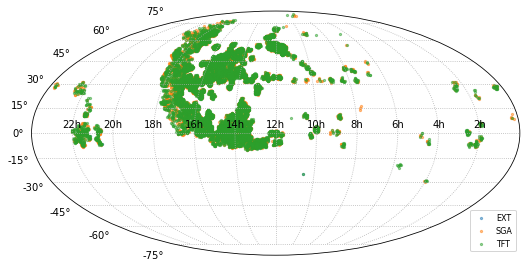

In [626]:
fig = plot_radec(tf_targets)

## Plot Target Redshifts

Extract good redshifts and plot the distributions as a function of target type.

In [627]:
isgoodz = (tf_targets['deltachi2']>= 25) & (tf_targets['zwarn']==0)
np.sum(isgoodz)

14977

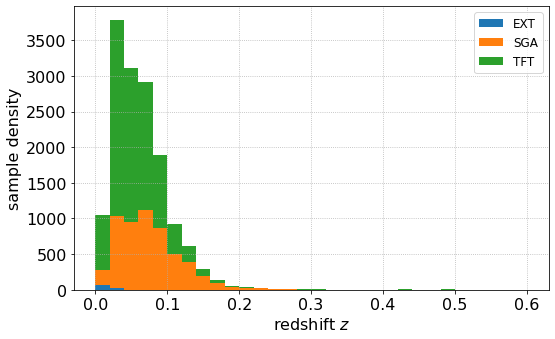

In [628]:
fig, ax = plt.subplots(1,1, figsize=(8,5), tight_layout=True)

zdata = []
pvtypes = np.unique(tf_targets['pvtype'])
for pvtype in pvtypes:
    ispvtype = tf_targets['pvtype'] == pvtype
    zdata.append(list(tf_targets[isgoodz & ispvtype]['z']))

zbins = np.linspace(0,0.6,31)
ax.hist(zdata, bins=zbins, stacked=True, label=pvtypes)
ax.set(#ylim=(0,15),
       xlabel='redshift $z$',
       ylabel='sample density')
ax.grid(ls=':')

ax.legend(fontsize=12);

## Read in list of PV Targets
PV targets from above desi query

In [629]:
PV_filename = 'tf_targets.fits'

In [630]:
hdu = fits.open(PV_filename)
PV_observed = QTable(hdu[1].data)
hdu.close()

In [639]:
len(PV_observed)

15405

In [631]:
PV_observed[:20]

pvtype,sga_id,targetid,target_ra,target_dec,z,spectype,deltachi2,zwarn,expid,yyyymmdd
str3,int64,int64,float64,float64,float64,str6,float64,int64,int64,int64
TFT,1285603,616088587867259427,150.085494347167,1.98540758430202,1.49757462439216,GALAXY,426.185304820538,0,68490,20201217
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,0.0102383463580575,GALAXY,332559.754650116,0,69412,20201222
SGA,249627,39628473387452348,36.6378025591632,29.8305673331864,0.0349532879812339,GALAXY,33952.1068879628,0,69412,20201222
SGA,581116,39628499509579686,36.0846931600021,30.9513934451943,0.046449435766605,GALAXY,53137.0094233155,0,69412,20201222
SGA,879849,39628478600971508,34.0579702049385,30.0920453747291,0.0445682338630569,GALAXY,33245.3577982187,0,69412,20201222
SGA,1215253,39628494279282283,33.8598111259499,30.8583242268397,0.054035597680716,GALAXY,11625.5793859102,0,69213,20201222
SGA,1329026,39628478600971529,34.0593021182507,30.1224101637649,0.0296421307118722,GALAXY,57099.7675513407,0,69412,20201222
TFT,161400,39628462826195756,35.3790466101176,29.23051056593,0.0589073438874499,GALAXY,12976.2707899213,0,69412,20201222
TFT,173880,39628457541371020,35.7235330211126,28.8880073711485,0.0339580769142768,GALAXY,4275.01541189849,0,69412,20201222


## Identify SGA Galaxies

In [632]:
SGA_filename = '/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits'

hdu = fits.open(SGA_filename)
SGA = QTable(hdu[1].data)
hdu.close()

In [633]:
SGA

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,2025p070,202.5

## Match DESI targets to SGA catalog

In [636]:
SGA_coords = SkyCoord(ra=SGA['RA']*u.degree, dec=SGA['DEC']*u.degree)
PV_coords = SkyCoord(ra=PV_observed['target_ra']*u.degree, dec=PV_observed['target_dec']*u.degree)

idx, sep2d, dist3d = match_coordinates_sky(PV_coords, SGA_coords, nthneighbor=1)

PV_observed['IDX_SGA'] = idx
PV_observed['SKY_TARGET_DIST_SGA'] = sep2d

### Stack the PV and SGA Tables

Make an `hstack` of the `PV_observed` and `SGA` tables using rows that matched PV coordinates to SGA centers. This will put all the relevant information into a single table that we'll call `PV_matched`.

In [637]:
PV_matched = hstack([PV_observed, SGA[idx]])

In [638]:
# Print the table to demonstrate that we've matched across the rows between PV_observed and SGA.
PV_matched

pvtype,sga_id,targetid,target_ra,target_dec,z,spectype,deltachi2,zwarn,expid,yyyymmdd,IDX_SGA,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
str3,int64,int64,float64,float64,float64,str6,float64,int64,int64,int64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
TFT,1285603,616088587867259427,150.085494347167,1.98540758430202,1.49757462439216,GALAXY,426.185304820538,0,68490,20201217,155617,0.03418493296074958,586473,SGA-2020 586473,PGC1212737,1212737,150.0544275,1.9996804,Sm,8.62,0.40364543,0.35892195,0.07842992,24.296482,17.638,False,LEDA-20181114,212551,PGC1212737,1,True,150.0544275,1.9996804,0.40364543,1501p020,150.05439129726653,1.9996335960144143,0.67049366,SB26,10.36681,0.28705108,150.05430178911885,1.999716561114591,12.422118,5.050954,5.047632,5.4049172,8.3039665,9.606885,10.852014,11.968115,12.912382,14.227189,16.03915,18.16351,20.114809,17.201572,16.16524,15.398829,17.099644,16.077265,15.312557,17.023075,16.0078,15.244353,16.97123,15.978369,15.218419,16.935139,15.9605465,15.204625,16.910652,15.945327,15.188659,16.891752,15.93023,15.1755295,16.87439,15.918931,15.163785,16.861664,15.911847,15.155255,0.11472259,0.12143157,0.091529936,0.13053448,0.12436708,0.14294966,0.1715582,0.24258737,0.21266633,0.048004877,0.05472816,0.05768016,0.044963147,0.051532526,0.054303557,0.04270379,0.04903814,0.051707167,0.041212562,0.04791116,0.050638866,0.040177908,0.04721353,0.05005141,0.039422147,0.046618827,0.049374927

#### Sanity Check: Matching SGA IDs?

Making the `hstack` of the `PV_observed` and `SGA` tables changes some of the columns in the merged table. After the stack:
- `SGA_ID` in `PV_observed` becomes `SGA_ID_1`. This corresponds to the SGA ID returned by the database query of TF targets at NERSC.
- `SGA_ID` in `SGA` becomes `SGA_ID_2` in the merged table. This is the SGA ID of the galaxy that is the nearest neighbor of the DESI target in each row of the merged table.

Note that many if not most of the `SGA_ID_1` values will be zero b/c that's what is returned by the current query (as of end of June 2021). Here we check that when `SGA_ID_1` is nonzero, then it matches `SGA_ID_2`. For cases that don't match, it may be due to the fact that the correct SGA ID is *not* the nearest neighbor of that particular DESI target. 

In [652]:
# Grab a boolean array where the sga_id is nonzero.
is_nonzero_id = PV_matched['sga_id'] != 0

# For all rows where sga_id is nonzero, print sga_id and SGA_ID.
PV_matched[is_nonzero_id]['sga_id', 'SGA_ID']

sga_id,SGA_ID
int64,int64
1285603,586473
227887,227887
249627,249627
581116,581116
879849,879849
1215253,1215253
1329026,1329026
161400,161400
173880,173880


In [646]:
# Returns a list of unique SGA_ID (the SGA_ID from the SGA table) and the number of times that ID is in our table.
unique_ids, id_counts = np.unique(PV_matched['SGA_ID'], return_counts=True)

print(id_counts)

[1 1 1 ... 1 1 1]


In [653]:
# Select the IDs that match more than one row in our table.
is_multiple_sga = id_counts > 1
multiple_sga_ids = unique_ids[is_multiple_sga]
for multiple_sga_id in multiple_sga_ids:
    select = PV_matched['SGA_ID'] == multiple_sga_id
    multiple_SGA = PV_matched[select]
    print(multiple_SGA)

pvtype  sga_id      targetid      ... Z_COG_PARAMS_CHI2 ELLIPSEBIT
                                  ...                             
------ ------- ------------------ ... ----------------- ----------
   TFT     146  39633358845643204 ...       0.007930444          0
   SGA 1016335 616094114374484114 ...       0.007930444          0
pvtype sga_id      targetid      ... Z_COG_PARAMS_CHI2 ELLIPSEBIT
                                 ...                             
------ ------ ------------------ ... ----------------- ----------
   TFT 901112 616088552098234624 ...       0.022002598          0
   SGA   1563  39627793759208260 ...       0.022002598          0
pvtype sga_id      targetid      ... Z_COG_PARAMS_CHI2 ELLIPSEBIT
                                 ...                             
------ ------ ------------------ ... ----------------- ----------
   SGA 106747 616093704121221370 ...         1.0723646          0
   SGA   8158  39632951817801333 ...         1.0723646          0
pvtyp

## Eliminate non-SGA galaxies

All the objects from the query should already be associated with an SGA object. This cuts out 94 targets. **Take a look at these targets to figure out if anything is going on here**

In [654]:
#sep_constraint = PV_matched['SKY_TARGET_DIST_SGA'] <= 0.5*SGA['D26'][PV_matched['IDX_SGA']]*u.arcmin
#PV_SGA_observed = PV_matched[sep_constraint]

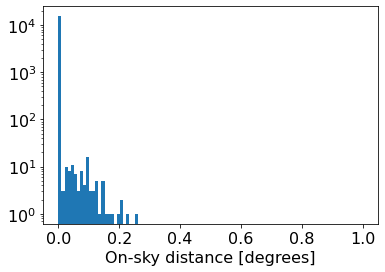

In [655]:
plt.figure()

plt.hist(PV_observed['SKY_TARGET_DIST_SGA'].data, bins=np.linspace(0, 1, 100))
#plt.hist(PV_SGA_observed['SKY_TARGET_DIST_SGA'].data, bins=np.linspace(0,1,100))

plt.yscale('log')

plt.xlabel('On-sky distance [degrees]');

## Define a function to evaluate arbitrary SGA ellipses

The table is expected to be same as the previous one. However, 14 targets were cut out. **Look into these 14 targets.**

Also, 2 of the targets do not fall within nearby SGA ellipses. **Look into these targets as well.**

In [657]:
diameter = PV_matched['D26']
PA = PV_matched['PA']*(np.pi/180)
BA = PV_matched['BA']

#replace center_ra and center_dec with center_coords, same for target ra and dec 
center_ra = (PV_matched['RA'])/(np.cos(PV_matched['DEC']*(np.pi/180)))
center_dec = PV_matched['DEC']
ra_observed = (PV_matched['target_ra'])/(np.cos(PV_matched['target_dec']*(np.pi/180)))
dec_observed = PV_matched['target_dec']

B = PV_matched['BA']*(0.5*diameter)
A = B*(1/(PV_matched['BA']))

In [658]:
#check astropy database (starting with website kelly sent) and google for how to define an ellipse on the sky
#can offset carry over?
C = ((ra_observed - center_ra)*np.cos(PA))+((dec_observed - center_dec)*np.sin(PA))
D = ((dec_observed - center_dec)*np.cos(PA))-((ra_observed - center_ra)*np.sin(PA))
ellipse = ((C**2)/(A**2)) + ((D**2)/(B**2))
good_boolean = ellipse <= 1
galaxy_targets = PV_matched[good_boolean]

In [659]:
len(galaxy_targets)

15367

In [660]:
#look at second nearest galaxy for cut galaxies

idx, sep2d, dist3d = match_coordinates_sky(PV_coords[~good_boolean], SGA_coords, nthneighbor=2)

PV_observed['IDX_SGA'][~good_boolean] = idx
PV_observed['SKY_TARGET_DIST_SGA'][~good_boolean] = sep2d

In [661]:
PV_matched = hstack([PV_observed, SGA[PV_observed['IDX_SGA']]])

In [662]:
diameter = PV_matched['D26']
PA = PV_matched['PA']*(np.pi/180)
BA = PV_matched['BA']
center_ra = (PV_matched['RA'])/(np.cos(PV_matched['DEC']*(np.pi/180)))
center_dec = PV_matched['DEC']
ra_observed = (PV_matched['target_ra'])/(np.cos(PV_matched['target_dec']*(np.pi/180)))
dec_observed = PV_matched['target_dec']

B = PV_matched['BA']*(0.5*diameter)
A = B*(1/(PV_matched['BA']))

In [663]:
C = ((ra_observed - center_ra)*np.cos(PA))+((dec_observed - center_dec)*np.sin(PA))
D = ((dec_observed - center_dec)*np.cos(PA))-((ra_observed - center_ra)*np.sin(PA))
ellipse = ((C**2)/(A**2)) + ((D**2)/(B**2))
good_boolean = ellipse <= 1
galaxy_targets = PV_matched[good_boolean]

In [664]:
len(galaxy_targets)

15375

In [665]:
#look at 3rd nearest neighbor 
idx, sep2d, dist3d = match_coordinates_sky(PV_coords[~good_boolean], SGA_coords, nthneighbor=3)

PV_observed['IDX_SGA'][~good_boolean] = idx
PV_observed['SKY_TARGET_DIST_SGA'][~good_boolean] = sep2d

In [666]:
PV_matched = hstack([PV_observed, SGA[PV_observed['IDX_SGA']]])

In [667]:
diameter = PV_matched['D26']
PA = PV_matched['PA']*(np.pi/180)
BA = PV_matched['BA']
center_ra = (PV_matched['RA'])/(np.cos(PV_matched['DEC']*(np.pi/180)))
center_dec = PV_matched['DEC']
ra_observed = (PV_matched['target_ra'])/(np.cos(PV_matched['target_dec']*(np.pi/180)))
dec_observed = PV_matched['target_dec']

B = PV_matched['BA']*(0.5*diameter)
A = B*(1/(PV_matched['BA']))

In [668]:
C = ((ra_observed - center_ra)*np.cos(PA))+((dec_observed - center_dec)*np.sin(PA))
D = ((dec_observed - center_dec)*np.cos(PA))-((ra_observed - center_ra)*np.sin(PA))
ellipse = ((C**2)/(A**2)) + ((D**2)/(B**2))
good_boolean = ellipse <= 1
galaxy_targets = PV_matched[good_boolean]

In [669]:
len(galaxy_targets)

15380

In [670]:
#look at 4th nearest neighbor
idx, sep2d, dist3d = match_coordinates_sky(PV_coords[~good_boolean], SGA_coords, nthneighbor=4)

PV_observed['IDX_SGA'][~good_boolean] = idx
PV_observed['SKY_TARGET_DIST_SGA'][~good_boolean] = sep2d

In [671]:
PV_matched = hstack([PV_observed, SGA[PV_observed['IDX_SGA']]])

In [672]:
len(PV_matched)

15405

In [673]:
diameter = PV_matched['D26']
PA = PV_matched['PA']*(np.pi/180)
BA = PV_matched['BA']
center_ra = (PV_matched['RA'])/(np.cos(PV_matched['DEC']*(np.pi/180)))
center_dec = PV_matched['DEC']
ra_observed = (PV_matched['target_ra'])/(np.cos(PV_matched['target_dec']*(np.pi/180)))
dec_observed = PV_matched['target_dec']

B = PV_matched['BA']*(0.5*diameter)
A = B*(1/(PV_matched['BA']))

In [674]:
C = ((ra_observed - center_ra)*np.cos(PA))+((dec_observed - center_dec)*np.sin(PA))
D = ((dec_observed - center_dec)*np.cos(PA))-((ra_observed - center_ra)*np.sin(PA))
ellipse = ((C**2)/(A**2)) + ((D**2)/(B**2))
good_boolean = ellipse <= 1
galaxy_targets = PV_matched[good_boolean]

In [675]:
len(galaxy_targets)

15383

In [676]:
#look at 5th closest neighbor
idx, sep2d, dist3d = match_coordinates_sky(PV_coords[~good_boolean], SGA_coords, nthneighbor=5)

PV_observed['IDX_SGA'][~good_boolean] = idx
PV_observed['SKY_TARGET_DIST_SGA'][~good_boolean] = sep2d

In [677]:
PV_matched = hstack([PV_observed, SGA[PV_observed['IDX_SGA']]])

In [679]:
diameter = PV_matched['D26']
PA = PV_matched['PA']*(np.pi/180)
BA = PV_matched['BA']
center_ra = (PV_matched['RA'])/(np.cos(PV_matched['DEC']*(np.pi/180)))
center_dec = PV_matched['DEC']
ra_observed = (PV_matched['target_ra'])/(np.cos(PV_matched['target_dec']*(np.pi/180)))
dec_observed = PV_matched['target_dec']

B = PV_matched['BA']*(0.5*diameter)
A = B*(1/(PV_matched['BA']))

In [680]:
C = ((ra_observed - center_ra)*np.cos(PA))+((dec_observed - center_dec)*np.sin(PA))
D = ((dec_observed - center_dec)*np.cos(PA))-((ra_observed - center_ra)*np.sin(PA))
ellipse = ((C**2)/(A**2)) + ((D**2)/(B**2))
good_boolean = ellipse <= 1
galaxy_targets = PV_matched[good_boolean]

In [681]:
len(galaxy_targets)

15384

In [682]:
#look at 6th closest neighbor
idx, sep2d, dist3d = match_coordinates_sky(PV_coords[~good_boolean], SGA_coords, nthneighbor=6)

PV_observed['IDX_SGA'][~good_boolean] = idx
PV_observed['SKY_TARGET_DIST_SGA'][~good_boolean] = sep2d

In [683]:
PV_matched = hstack([PV_observed, SGA[PV_observed['IDX_SGA']]])

In [684]:
diameter = PV_matched['D26']
PA = PV_matched['PA']*(np.pi/180)
BA = PV_matched['BA']
center_ra = (PV_matched['RA'])/(np.cos(PV_matched['DEC']*(np.pi/180)))
center_dec = PV_matched['DEC']
ra_observed = (PV_matched['target_ra'])/(np.cos(PV_matched['target_dec']*(np.pi/180)))
dec_observed = PV_matched['target_dec']

B = PV_matched['BA']*(0.5*diameter)
A = B*(1/(PV_matched['BA']))

In [685]:
C = ((ra_observed - center_ra)*np.cos(PA))+((dec_observed - center_dec)*np.sin(PA))
D = ((dec_observed - center_dec)*np.cos(PA))-((ra_observed - center_ra)*np.sin(PA))
ellipse = ((C**2)/(A**2)) + ((D**2)/(B**2))
good_boolean = ellipse <= 1
galaxy_targets = PV_matched[good_boolean]

In [686]:
len(galaxy_targets)

15386

In [687]:
#look at 7th closest neighbor
idx, sep2d, dist3d = match_coordinates_sky(PV_coords[~good_boolean], SGA_coords, nthneighbor=7)

PV_observed['IDX_SGA'][~good_boolean] = idx
PV_observed['SKY_TARGET_DIST_SGA'][~good_boolean] = sep2d

In [688]:
PV_matched = hstack([PV_observed, SGA[PV_observed['IDX_SGA']]])

In [690]:
diameter = PV_matched['D26']
PA = PV_matched['PA']*(np.pi/180)
BA = PV_matched['BA']
center_ra = (PV_matched['RA'])/(np.cos(PV_matched['DEC']*(np.pi/180)))
center_dec = PV_matched['DEC']
ra_observed = (PV_matched['target_ra'])/(np.cos(PV_matched['target_dec']*(np.pi/180)))
dec_observed = PV_matched['target_dec']

B = PV_matched['BA']*(0.5*diameter)
A = B*(1/(PV_matched['BA']))

In [691]:
C = ((ra_observed - center_ra)*np.cos(PA))+((dec_observed - center_dec)*np.sin(PA))
D = ((dec_observed - center_dec)*np.cos(PA))-((ra_observed - center_ra)*np.sin(PA))
ellipse = ((C**2)/(A**2)) + ((D**2)/(B**2))
good_boolean = ellipse <= 1
galaxy_targets = PV_matched[good_boolean]

In [692]:
len(galaxy_targets)

15388

In [693]:
#look at 8th closest neighbor
idx, sep2d, dist3d = match_coordinates_sky(PV_coords[~good_boolean], SGA_coords, nthneighbor=8)

PV_observed['IDX_SGA'][~good_boolean] = idx
PV_observed['SKY_TARGET_DIST_SGA'][~good_boolean] = sep2d

In [694]:
PV_matched = hstack([PV_observed, SGA[PV_observed['IDX_SGA']]])

In [695]:
diameter = PV_matched['D26']
PA = PV_matched['PA']*(np.pi/180)
BA = PV_matched['BA']
center_ra = (PV_matched['RA'])/(np.cos(PV_matched['DEC']*(np.pi/180)))
center_dec = PV_matched['DEC']
ra_observed = (PV_matched['target_ra'])/(np.cos(PV_matched['target_dec']*(np.pi/180)))
dec_observed = PV_matched['target_dec']

B = PV_matched['BA']*(0.5*diameter)
A = B*(1/(PV_matched['BA']))

In [696]:
C = ((ra_observed - center_ra)*np.cos(PA))+((dec_observed - center_dec)*np.sin(PA))
D = ((dec_observed - center_dec)*np.cos(PA))-((ra_observed - center_ra)*np.sin(PA))
ellipse = ((C**2)/(A**2)) + ((D**2)/(B**2))
good_boolean = ellipse <= 1
galaxy_targets = PV_matched[good_boolean]

In [697]:
len(galaxy_targets)

15388

## Identify the centers and on-axis observations 

In [698]:
distance_from_center = galaxy_targets['SKY_TARGET_DIST_SGA']
SGA_radius = 0.5*galaxy_targets['D26']*u.arcsec

In [699]:
distance_from_center

<Angle [3.41849330e-02, 4.49389075e-14, 4.18041415e-14, ...,
        1.73689984e-13, 2.27224315e-13, 2.84046606e-13] deg>

In [700]:
center_check = distance_from_center.to(u.arcsec) <= 0.005*SGA_radius

In [701]:
centers = galaxy_targets[center_check]

In [702]:
centers

pvtype,sga_id,targetid,target_ra,target_dec,z,spectype,deltachi2,zwarn,expid,yyyymmdd,IDX_SGA,SKY_TARGET_DIST_SGA,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
,,,,,,,,,,,,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
str3,int64,int64,float64,float64,float64,str6,float64,int64,int64,int64,int64,float64,int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
SGA,227887,39628509848540752,34.8173069688145,31.3984950009448,0.0102383463580575,GALAXY,332559.754650116,0,69412,20201222,60758,4.493890748991992e-14,227887,SGA-2020 227887,PGC008852,8852,34.817458499999994,31.3985278,Sc,47.0,0.64565426,0.50699073,0.010257095,23.34948,15.671,False,LEDA-20181114,80819,PGC008852,1,True,34.817458499999994,31.3985278,0.64565426,0346p315,34.817306968814506,31.398495000944845,1.2628791,SB26,46.69509,0.44351774,34.817144987779656,31.39853435338646,27.821953,7.5643625,7.751205,8.018863,11.525722,14.140119,17.078676,20.250322,23.686016,27.286552,30.939543,34.54722,37.886375,15.656424,14.952178,14.416003,15.541749,14.834224,14.296817,15.452583,14.743252,14.206147,15.386299,14.674229,14.137649,15.334078,14.620995,14.084178,15.295982,14.582026,14.045881,15.268926,14.553481,14.018,15.249975,14.534507,13.997845,15.23794,14.522351,13.984281,0.037277393,0.061759222,0.063091725,0.10513751,0.068378456,0.08847286,0.11017215,0.1338445,0.14169279,0.013537007,0.01256346,0.011847482,0.012311069,0.011419123,0.010781854,0.011420003,0.010592375,0.010021184,0.010789593,0.009995378,0.009472868,0.010305492,0.009542425,0.009043296,0.009962468,0.

## Calculate Rotation Velocity from the Redshift Data

For a given SGA galaxy, we can match that center with all other rows in the targets data file that have the same SGA ID. These include the TFT and EXT targets. The goal is to find SGA observations with at least one TFT or EXT target.

We can check this by using the ellipse function created in the previous section.